## Protein-Peptide Docking Score Prediction

This notebook is a reference to an implementation of a deep learning NLP method to predict docking
score of a peptide just using amino acid sequence.

#### Loading dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import random
import zipfile
import glob
import os
pd.options.mode.chained_assignment = None
random.seed(1234)

#### Reading the data

In [2]:
file_path=glob.glob("*.zip")
zf = zipfile.ZipFile(file_path[0])
extension='csv'

dfs= {os.path.basename(f)[:-4]:pd.read_csv(zf.open(f), header=None) for f in zf.namelist() if f.endswith(extension)}

print('-'*100)
print(dfs.keys())

print('-'*100)
print(dfs.values())

----------------------------------------------------------------------------------------------------
dict_keys(['test', 'train', '._train'])
----------------------------------------------------------------------------------------------------
dict_values([          0      1
0     -10.5  iinfv
1      -9.4  nvvnm
2      -9.0  titma
3      -9.8  vvvyc
4     -13.1  lkdrk
...     ...    ...
99831  -8.9  flpth
99832  -9.4  ipynd
99833  -8.9  ttteg
99834  -9.0  siacd
99835  -8.9  svrsq

[99836 rows x 2 columns],           0      1
0      -9.9  ghfcn
1     -10.2  ggwlt
2      -9.3  aamid
3      -9.1  mphwc
4     -11.5  hwytl
...     ...    ...
99842 -11.7  eqtkd
99843 -12.2  hkfyf
99844  -9.6  eataw
99845 -10.2  cgalk
99846  -9.8  kpkdf

[99847 rows x 2 columns],     0
0 NaN])


In [3]:
df_train=dfs['train']
df_test=dfs['test']

#### First Look

Scientific docking softwares estimates the strength of the interaction with protein and peptide. Peptides are composed of amino acids. There are 20 different amino acids. For example for the first row, -9.9 is the docking score and “ghfcn” is the amino acid sequence. Each letter shows one amino acid. In order to build a predictive model which takes the amino acid sequence as the input, it is necessary to divide the peptide sequence into characters.

Keras Tokenizer will be used to tokenize the amino acid sequences.

In [4]:
df_train.head()

,0,1
0,-9.9,ghfcn
1,-10.2,ggwlt
2,-9.3,aamid
3,-9.1,mphwc
4,-11.5,hwytl


In [5]:
texts=df_train[1].values

In [6]:
print(len(texts))
print(texts[:2])

99847
['ghfcn' 'ggwlt']


In [7]:
def fit_tokenizer(texts):
    tk=tf.keras.preprocessing.text.Tokenizer(num_words=None, char_level=True, lower=True)
    tk.fit_on_texts(texts)
    return tk

In [8]:
tk=fit_tokenizer(texts)

In [9]:
tk.word_index

{'h': 1,
 'c': 2,
 'g': 3,
 'a': 4,
 'q': 5,
 'm': 6,
 'd': 7,
 'y': 8,
 't': 9,
 'p': 10,
 'e': 11,
 'n': 12,
 'i': 13,
 'w': 14,
 'l': 15,
 's': 16,
 'v': 17,
 'f': 18,
 'k': 19,
 'r': 20}

In [10]:
input_dim=len(tk.word_index)+1

In [11]:
from keras.preprocessing.sequence import pad_sequences
def create_sequences(tk, texts):
    sequences=tk.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, 5, padding='post')
    return padded_sequences

In [12]:
padded_sequences=create_sequences(tk, texts)
print(padded_sequences)

[[ 3  1 18  2 12]
 [ 3  3 14 15  9]
 [ 4  4  6 13  7]
 ...
 [11  4  9  4 14]
 [ 2  3  4 15 19]
 [19 10 19  7 18]]


In [13]:
input_len=len(padded_sequences[0])

### Model Building

#### Defining the model

Target variable is numerical and takes values between -14.8 and -5.9. Therefore, the problem is a regression problem.

Deep learning model with an embedding layer will be fitted on training data. Loss metric will be set as mean squared error(mse). In addition to MSE, mean absolute error(mae) and mean absolute percentage error(mape) will be analyzed.

In [14]:
df_train[0].describe()

count    99847.000000
mean       -10.209103
std          1.090540
min        -14.800000
25%        -10.900000
50%        -10.200000
75%         -9.500000
max         -5.900000
Name: 0, dtype: float64

#### Deep learning model with an embedding layer

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.optimizers import Adagrad

def model_init(input_dim, input_len):
    
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=input_len, input_length=input_len))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    
    # Initializing Adagrad optimizer
    opt = Adagrad(learning_rate=0.1)
    
    model.compile(optimizer=opt, loss='mse', 
              metrics=['MeanAbsoluteError', 'MeanAbsolutePercentageError'])
    
    return model

In [16]:
model=model_init(input_dim, input_len)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 5)              105       
_________________________________________________________________
flatten (Flatten)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
def model_train(model, x, y, epochs):
    history=model.fit(x, y, epochs=epochs, verbose=1)
    return history

In [18]:
history=model_train(model, padded_sequences, df_train[0], 20)

Epoch 1/20
3121/3121 [==============================] - 4s 943us/step - loss: 1.6908 - mean_absolute_error: 0.5773 - mean_absolute_percentage_error: 5.6517
Epoch 2/20
3121/3121 [==============================] - 3s 1ms/step - loss: 0.2101 - mean_absolute_error: 0.3590 - mean_absolute_percentage_error: 3.5174
Epoch 3/20
3121/3121 [==============================] - 3s 937us/step - loss: 0.2088 - mean_absolute_error: 0.3581 - mean_absolute_percentage_error: 3.5089
Epoch 4/20
3121/3121 [==============================] - 4s 1ms/step - loss: 0.2067 - mean_absolute_error: 0.3565 - mean_absolute_percentage_error: 3.4900
Epoch 5/20
3121/3121 [==============================] - 3s 978us/step - loss: 0.2066 - mean_absolute_error: 0.3564 - mean_absolute_percentage_error: 3.4924
Epoch 6/20
3121/3121 [==============================] - ETA: 0s - loss: 0.2071 - mean_absolute_error: 0.3564 - mean_absolute_percentage_error: 3.49 - 3s 1ms/step - loss: 0.2071 - mean_absolute_error: 0.3564 - mean_absolute_p

In [19]:
model.evaluate(padded_sequences, df_train[0], verbose=1)

3121/3121 [==============================] - 2s 712us/step - loss: 0.2071 - mean_absolute_error: 0.3597 - mean_absolute_percentage_error: 3.5360


[0.20709598064422607, 0.35965821146965027, 3.536001443862915]

In [20]:
test_texts=df_test[1].values
padded_test_sequences=create_sequences(tk, test_texts)
print(padded_test_sequences)

[[13 13 12 18 17]
 [12 17 17 12  6]
 [ 9 13  9  6  4]
 ...
 [ 9  9  9 11  3]
 [16 13  4  2  7]
 [16 17 20 16  5]]


In [21]:
model.evaluate(padded_test_sequences, df_test[0], verbose=1)

3120/3120 [==============================] - 3s 827us/step - loss: 0.2101 - mean_absolute_error: 0.3632 - mean_absolute_percentage_error: 3.5680


[0.21005292236804962, 0.3632102310657501, 3.5680267810821533]

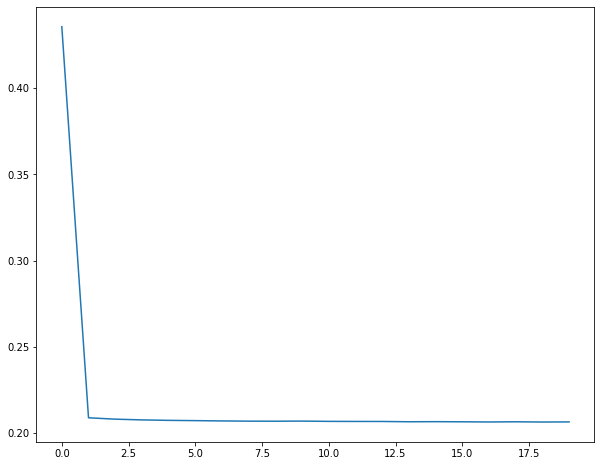

In [22]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss']);

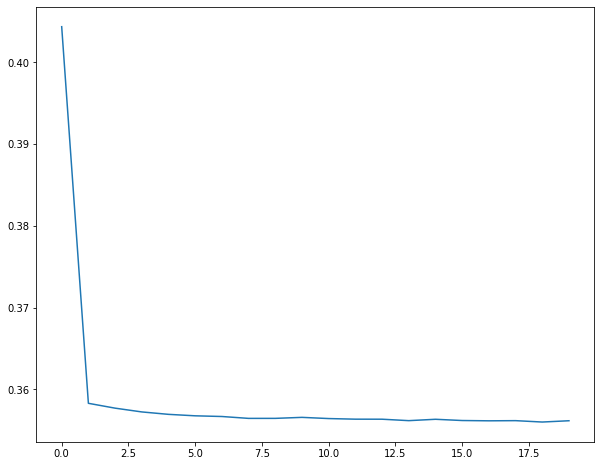

In [23]:
plt.figure(figsize=(10,8))
plt.plot(history.history['mean_absolute_error']);

In [24]:
test_pred=pd.DataFrame(model.predict(padded_test_sequences))

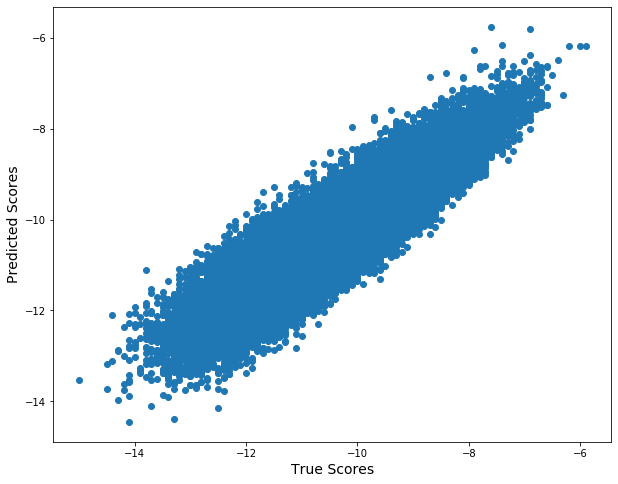

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(x=df_test[0], y=test_pred);
plt.xlabel('True Scores', size=14);
plt.ylabel('Predicted Scores', size=14);

In [26]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(df_test[0], test_pred)

print('Coefficient of determination, RSquared: '+str(coefficient_of_dermination))

Coefficient of determination, RSquared: 0.8232826566365605
